In [2]:
!pip install tensorflow
!pip install matplotlib
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.layers
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import random

from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import load_model
import PIL.Image as Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import (accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,roc_curve)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/Fish_Eye_Freshness.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  gdrive/MyDrive/Fish_Eye_Freshness.zip
replace Fish_Eye_Freshness/Fresh/IMG_20191002_062711.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062711.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062722.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062735.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062742.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062803.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062812.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062826.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062836.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062907.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062928.jpg  
  inflating: Fish_Eye_Freshness/Fresh/IMG_20191002_062944.jpg  
  inflating: Fish_E

In [4]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3


In [5]:

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Fish_Eye_Freshness",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4390 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Fresh', 'Highly Fresh', 'Not Fresh']

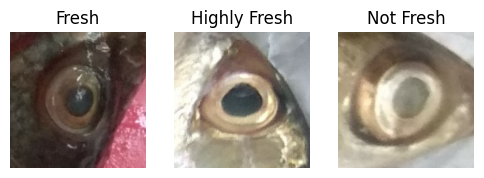

In [7]:
displayed_classes = {}
plt.figure(figsize=(6,6))

for image_batch, label_batch in dataset.take(1):
    i = 0
    for img, label in zip(image_batch, label_batch):
        class_label = label.numpy()

        if class_label not in displayed_classes:
            displayed_classes[class_label] = True
            plt.subplot(3, 3, i + 1)
            plt.imshow(img.numpy().astype("uint8"))
            plt.axis("off")
            plt.title(class_names[class_label])
            i += 1

        if i >= 3:
            break

plt.show()

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.80, val_split=0.10, test_split=0.10,shuffle=True, shuffle_size=1000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)

  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds
train_imgs,val_imgs,test_imgs=get_dataset_partitions_tf(dataset)
train_imgs=train_imgs.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_imgs=val_imgs.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_imgs=test_imgs.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])
train_imgs = train_imgs.map(lambda x, y: (resize_and_rescale(x), y))
val_imgs = val_imgs.map(lambda x, y: (resize_and_rescale(x), y))
test_imgs = test_imgs.map(lambda x, y: (resize_and_rescale(x), y))

In [10]:
train_imgs = train_imgs.shuffle(1000)
val_imgs = val_imgs.shuffle(1000)

In [11]:
import collections
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.05)
])

def augment_image(image, label):
    augmented_images = [data_augmentation(image, training=True) for _ in range(2)]
    return tf.data.Dataset.from_tensor_slices((augmented_images, [label]*2))

augmented_imgs = train_imgs.unbatch().flat_map(augment_image).batch(BATCH_SIZE)
all_train_imgs = train_imgs.concatenate(augmented_imgs)

all_train_imgs = all_train_imgs.shuffle(1000).prefetch(tf.data.AUTOTUNE)

augmented_count = sum(1 for _ in all_train_imgs.unbatch())
print(f"Total training images after augmentation: {augmented_count}")

train_class_counts = collections.defaultdict(int)
for _, label in all_train_imgs.unbatch():
    train_class_counts[int(label.numpy())] += 1

print("\nTraining images per category after augmentation:")
for category, count in train_class_counts.items():
    print(f"Class {category}: {count} images")

Total training images after augmentation: 10482

Training images per category after augmentation:
Class 0: 3123 images
Class 1: 4206 images
Class 2: 3153 images


In [12]:
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
base_model.trainable=False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = [
    ModelCheckpoint(filepath='model.keras', save_best_only=True, monitor='accuracy', mode='max',verbose=1),
    EarlyStopping(monitor='accuracy',mode='max', patience=5, restore_best_weights=True,verbose=1)
]
history=model.fit(all_train_imgs, validation_data=val_imgs, epochs=20,callbacks = callback,batch_size = BATCH_SIZE,verbose=1)
model.save('model.keras')
all_predictions=[]
all_labels=[]
for images,labels in test_imgs:
  predictions=model.predict(images)
  predicted_classes=np.argmax(predictions,axis=1)
  all_predictions.extend(predicted_classes)
  all_labels.extend(labels.numpy())
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)
print("Confusion Matrix: ",confusion_matrix(all_labels,all_predictions))

Epoch 1/20
    329/Unknown 92s 94ms/step - accuracy: 0.4724 - loss: 1.6002
Epoch 1: accuracy improved from -inf to 0.53692, saving model to model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 108s 144ms/step - accuracy: 0.4726 - loss: 1.5989 - val_accuracy: 0.5841 - val_loss: 0.8887
Epoch 2/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6703 - loss: 0.7773
Epoch 2: accuracy improved from 0.53692 to 0.67430, saving model to model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.6703 - loss: 0.7772 - val_accuracy: 0.7692 - val_loss: 0.5605
Epoch 3/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7317 - loss: 0.6354
Epoch 3: accuracy improved from 0.67430 to 0.72305, saving model to model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.7317 - loss: 0.6355 - val_accuracy: 0.7692 - val_loss: 0.5259
Epoch 4/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7480 - loss: 0.5897
Epoch 4: accuracy improved from 0.72305 to 0.75138, saving model to 

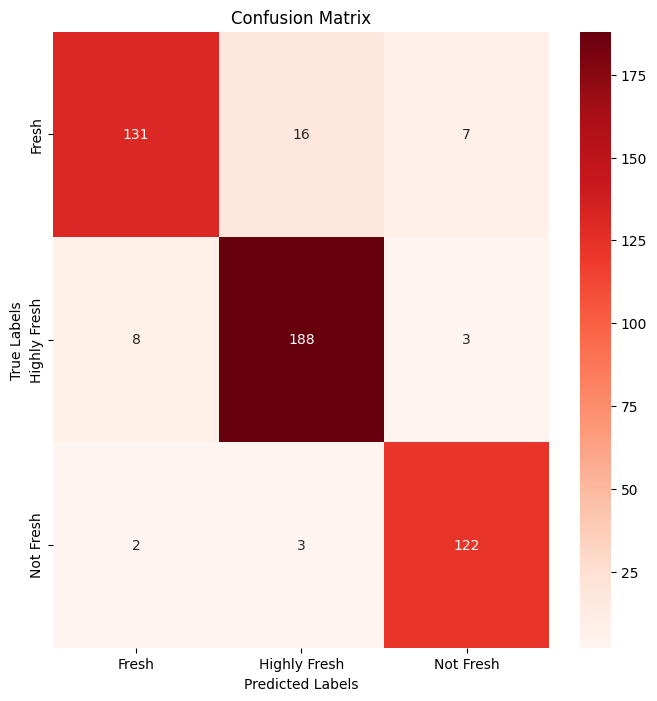

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(all_labels,all_predictions),annot=True,fmt="d",cmap="Reds",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Text(0.5, 1.0, 'Training and Validation Loss')

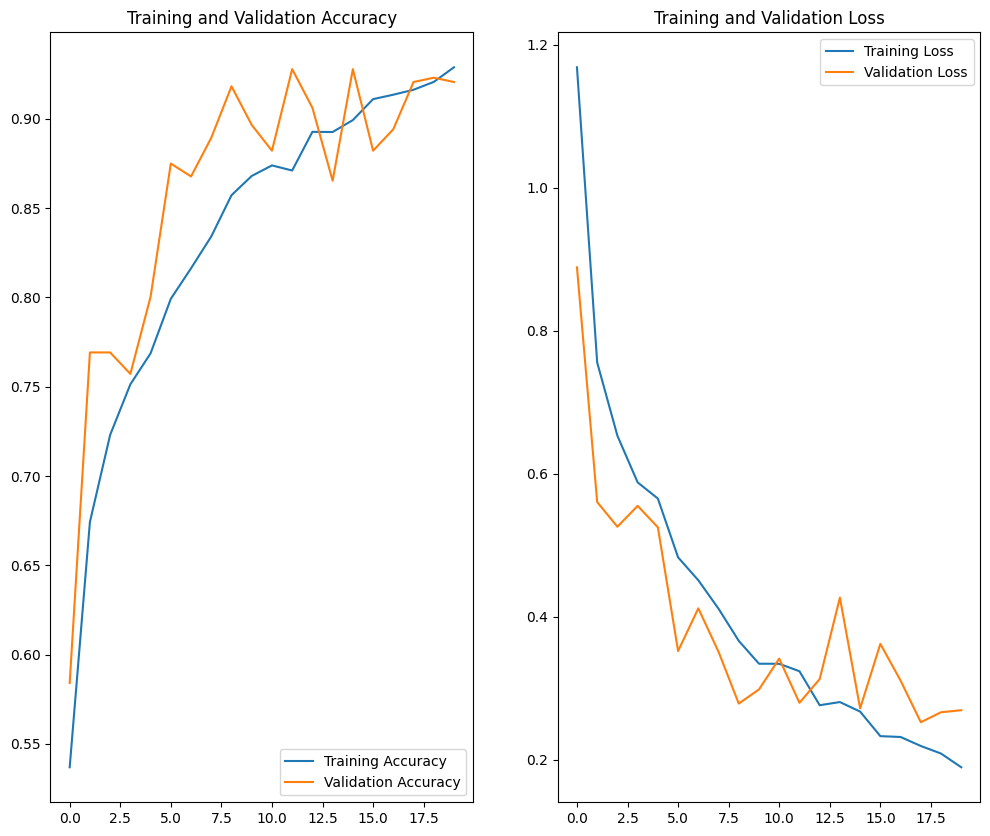

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [15]:
model = load_model('model.keras')

In [16]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    try:
        predicted_class = class_names[predicted_class_index]
    except NameError:
        raise NameError("Please define `class_names` as a list of class labels before calling this function.")
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print("Predicted class:", predicted_class)

In [18]:
keras_file="model.h5"
tf.keras.models.save_model(model,keras_file)
import os
print(os.listdir('.'))

from IPython.display import FileLink
FileLink(keras_file)

['.config', 'rotten fish 3.jpg', 'gdrive', '.ipynb_checkpoints', 'rotten fish 2.jpg', 'model.keras', 'model.h5', 'highly fresh fish 2.jpg', 'highly fresh fish 1.webp', 'Fish_Eye_Freshness', 'rotten fish 1.jpg', 'fresh fish 2.jpg', 'sample_data']


/content/model.h5